In [1]:
# Import stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow 
import tensorflow as tf
# You can avoid the long names by using
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
%matplotlib inline
import pdb

In [44]:
# Reparametrize
def reparametrize(t):

#     return 1+tf.math.multiply(t**2,mlp(t))
    return 1+tf.math.multiply((1-np.exp(-t))**2,mlp(t))
#    return 1+np.multiply(t,mlp(t))pdb

In [70]:
# 2 tapes

def matrixloss(batch):
#     pdb.set_trace()
    batch = tf.convert_to_tensor(batch.reshape(-1,1),dtype='float32')
    batch = tf.Variable(batch)
    with tf.GradientTape() as outtape:
        with tf.GradientTape() as intape:
    # forward pass - show the actual computation of the variable
            x = reparametrize(batch)
        dx = intape.gradient(x,batch)
    d2x = outtape.gradient(dx,batch)
    
    
    def custom_loss(x_true,x_pred):
        x = reparametrize(batch)
        loss = tf.reduce_mean((d2x+x)**2)
        return loss
    
    return custom_loss   

In [101]:
# 2 tapes

def pavloss(batch,eta=0):
#     pdb.set_trace()
    batch = batch = tf.convert_to_tensor(batch.reshape(-1,1),dtype='float32')
    batch = tf.Variable(batch)
    with tf.GradientTape() as outtape:
        with tf.GradientTape() as intape:
    # forward pass - show the actual computation of the variable
            x = reparametrize(batch)
        dx = intape.gradient(x,batch)
    d2x = outtape.gradient(dx,batch)
    
    # Computation of the posterior anterior variation
    batch = tf.convert_to_tensor(batch)
    nt = batch.shape[0]
    x = tf.convert_to_tensor(x)
    tpa = tf.exp(-(tf.broadcast_to(batch, [nt,nt]) - tf.reshape(batch,[-1]))**2)
    xpa = (tf.broadcast_to(x, [nt,nt]) - tf.reshape(x,[-1]))**2
    pav = eta*tf.reduce_mean(tpa*xpa)
    
    
    def custom_loss(x_true,x_pred):
        x = reparametrize(batch)
        loss = tf.reduce_mean((d2x+x)**2)
        return pav+loss
#         return pav+loss,pav,loss       
    
    return custom_loss   

In [100]:
# 2 tapes

def pavloss2(batch,eta=0):
#     pdb.set_trace()
    batch = batch = tf.convert_to_tensor(batch.reshape(-1,1),dtype='float32')
    batch = tf.Variable(batch)
    with tf.GradientTape() as outtape:
        with tf.GradientTape() as intape:
    # forward pass - show the actual computation of the variable
            x = reparametrize(batch)
        dx = intape.gradient(x,batch)
    d2x = outtape.gradient(dx,batch)
    
    # Computation of the posterior anterior variation
    batch = tf.convert_to_tensor(batch)
    nt = batch.shape[0]
    x = tf.convert_to_tensor(x)
    tpa = tf.exp(-(tf.broadcast_to(batch, [nt,nt]) - tf.reshape(batch,[-1]))**2)
    xpa = tf.reduce_mean(tf.math.multiply((tf.broadcast_to(x,[nt,nt])*tf.reshape(x,[-1,1])),tf.ones([nt,nt]) - tf.eye(nt)))
    pav = eta*tf.reduce_mean(tpa*xpa)
    
    
    def custom_loss(x_true,x_pred):
        x = reparametrize(batch)
        loss = tf.reduce_mean((d2x+x)**2)
        return pav+loss
#         return pav+loss,pav,loss       
    
    return custom_loss   

In [104]:
np.random.seed(0)
# matrixloss(batch)(1,2)
pavloss(batch,eta=1)(1,2)
pavloss2(batch,eta=1)(1,2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.19740991>

In [105]:
## space definition

nt = 512
num_samples = 4
batch_size = 128
t_space = np.linspace(-2,8,nt)
x = np.cos(-t_space)


In [91]:
np.random.seed(0)
# matrixloss(np.random.choice(t_space,batch_size))(5,5)

pavloss(np.random.choice(t_space,batch_size),eta=1)(5,5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.17571256>

In [47]:
## space definition

nt = 16
num_samples = 4
batch_size = 4
t_space = np.linspace(-2,8,nt)
x = np.cos(-t_space)


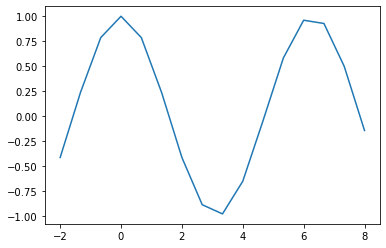

In [48]:
# Sample plot to see if everything is alright

plt.plot(t_space,x)

In [106]:
# Network model 1 - 4 - 4- 1

mlp = keras.Sequential(
    [
        keras.layers.Dense(50, activation=tf.nn.tanh,dtype='float32'),
        keras.layers.Dense(50, activation=tf.nn.tanh,dtype='float32'),        
        keras.layers.Dense(1, activation=keras.activations.linear)
    ]
)

In [ ]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_list = []

num_epochs = 1000

# Doing this for at least 100 epochs

epochs = num_epochs

for i in range(epochs):
    
    for sampling in range(num_samples):

        batch = np.random.choice(t_space,batch_size)
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Loss value for this batch.
#             loss = matrixloss(batch)(x, 5)
            loss = pavloss(batch, eta=1)(1,2)


        # Get gradients of weights wrt the loss.
        gradients = tape.gradient(loss, mlp.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

        # Logging.
    epoch_loss = pavloss(t_space)(1,2)
    if i%100 ==0:
        print("Epoch:", i, "Loss:", float(epoch_loss))
    loss_list.append(float(epoch_loss))

Epoch: 0 Loss: 2.291353225708008
Epoch: 100 Loss: 0.21916022896766663
Epoch: 200 Loss: 0.22049392759799957
Epoch: 300 Loss: 0.20910970866680145
Epoch: 400 Loss: 0.1947597861289978


In [ ]:
x_pred = reparametrize(t_space.reshape(-1,1))

fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(t_space, x,'-',linewidth=2,alpha=0.7, label = 'True function value', markersize = 10, color = 'red')
ax[0].plot(t_space, x_pred,'o',linewidth=2, alpha=0.7, label='network predictions',markersize=4,color='darkblue')
ax[0].set_xlabel('$t$',fontsize=24)
ax[0].set_ylabel('$x$',fontsize=24)
ax[0].legend();
ax[0].set_title('$\ddot{x} + x = 0$',fontsize=36);


ax[1].plot(np.log10(loss_list))
ax[1].set_title('Trace plot of loss',fontsize=23);
ax[1].set_title('Trace plot',fontsize=24);
ax[1].set_xlabel('$epochs$',fontsize=18)
ax[1].set_ylabel('$log$ loss',fontsize=18)
plt.tight_layout()

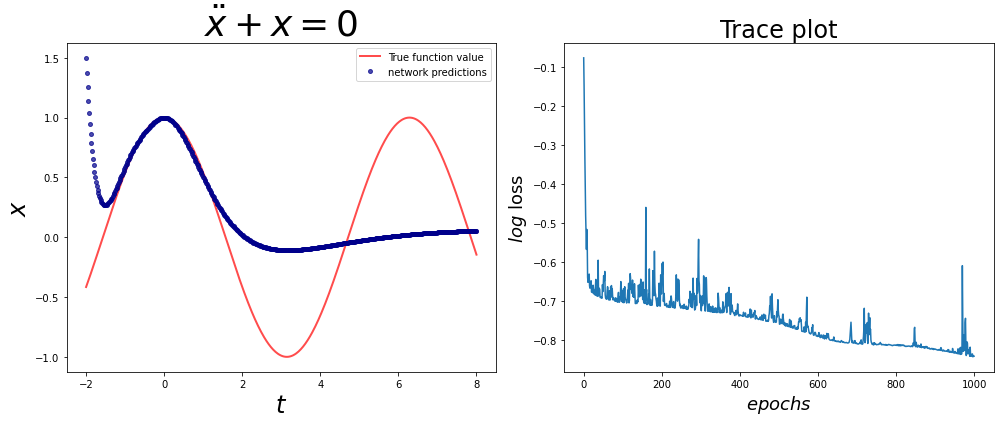

In [89]:
x_pred = reparametrize(t_space.reshape(-1,1))

fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(t_space, x,'-',linewidth=2,alpha=0.7, label = 'True function value', markersize = 10, color = 'red')
ax[0].plot(t_space, x_pred,'o',linewidth=2, alpha=0.7, label='network predictions',markersize=4,color='darkblue')
ax[0].set_xlabel('$t$',fontsize=24)
ax[0].set_ylabel('$x$',fontsize=24)
ax[0].legend();
ax[0].set_title('$\ddot{x} + x = 0$',fontsize=36);


ax[1].plot(np.log10(loss_list))
ax[1].set_title('Trace plot of loss',fontsize=23);
ax[1].set_title('Trace plot',fontsize=24);
ax[1].set_xlabel('$epochs$',fontsize=18)
ax[1].set_ylabel('$log$ loss',fontsize=18)
plt.tight_layout()

In [156]:
# Network model 1 - 4 - 1

mlp2 = keras.Sequential(
    [
        keras.layers.Dense(4, activation=tf.nn.tanh,dtype='float32'),
#         keras.layers.Dense(4, activation=tf.nn.relu,dtype='float32'),        
        keras.layers.Dense(1, activation=keras.activations.linear)
    ]
)

In [157]:
# 2 tapes
def matrixloss(batch):
#     pdb.set_trace()
    batch = batch = tf.convert_to_tensor(batch.reshape(-1,1),dtype='float32')
    batch = tf.Variable(batch)
    with tf.GradientTape() as outtape:
        with tf.GradientTape() as intape:
    # forward pass - show the actual computation of the variable
            x = unbundle(batch)
        dx = intape.gradient(x,batch)
    d2x = outtape.gradient(dx,batch)
    
    
    def custom_loss(x_true,x_pred):
        x = unbundle(batch)
        loss = tf.reduce_mean((d2x+x)**2)
        return loss
    
    return custom_loss   

In [13]:
# 2 tapes
def pavloss(batch,switch=0,eta=0):
#     pdb.set_trace()
    batch = batch = tf.convert_to_tensor(batch.reshape(-1,1),dtype='float32')
    batch = tf.Variable(batch)
    with tf.GradientTape() as outtape:
        with tf.GradientTape() as intape:
    # forward pass - show the actual computation of the variable
            x = reparametrize(batch)
        dx = intape.gradient(x,batch)
    d2x = outtape.gradient(dx,batch)
    
    # Computation of the posterior anterior variation
    batch = tf.convert_to_tensor(batch)
    nt = batch.shape[0]
    x = tf.convert_to_tensor(x)
    tpa = tf.exp(-(tf.broadcast_to(batch, [nt,nt]) - tf.reshape(batch,[-1]))**2)
    xpa = (tf.broadcast_to(x, [nt,nt]) - tf.reshape(x,[-1]))**2
    pav = eta*tf.reduce_mean(tpa*xpa)
    
    
    def custom_loss(x_true,x_pred):
        x = reparametrize(batch)
        loss = tf.reduce_mean((d2x+x)**2)
        if switch ==1:
            return pav+loss        
        return loss
    
    return custom_loss   

In [15]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

loss_list = []

# Doing this for at least 100 epochs

epochs = num_epochs

for i in range(epochs):
    
    for sampling in range(num_samples):

        batch = np.random.choice(t_space,batch_size)
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Loss value for this batch.
#             loss = matrixloss(batch)(x, 5)
            loss = pavloss(batch, switch=1, eta=10)(1,2)


        # Get gradients of weights wrt the loss.
        gradients = tape.gradient(loss, mlp.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

        # Logging.
    epoch_loss = pavloss(t_space)(1,2)
    if i%100 ==0:
        print("Epoch:", i, "Loss:", float(epoch_loss))
    loss_list.append(float(epoch_loss))

Epoch: 0 Loss: 1.211977481842041
Epoch: 100 Loss: 0.05299052596092224
Epoch: 200 Loss: 6.678401947021484
Epoch: 300 Loss: 0.05697298049926758
Epoch: 400 Loss: 0.04667867720127106
Epoch: 500 Loss: 0.054684218019247055
Epoch: 600 Loss: 0.050151385366916656
Epoch: 700 Loss: 0.056395646184682846
Epoch: 800 Loss: 0.05121709778904915
Epoch: 900 Loss: 0.05289210379123688


In [22]:
x_pred = unbundle(tf.constant(t_space.reshape(-1,1),dtype='float32'))
                  
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(t_space, x,'o-',linewidth=2,alpha=0.7, label = 'True function value', markersize = 10, color = 'red')
ax[0].plot(t_space, x_pred,'-',linewidth=2, alpha=0.7, label='network predictions',markersize=10,color='darkblue')
ax[0].set_xlabel('$t$',fontsize=24)
ax[0].set_ylabel('$x$',fontsize=24)
ax[0].legend();
ax[0].set_title('$\ddot{x} + x = 0$',fontsize=36);


ax[1].plot(np.log10(loss_list))
ax[1].set_title('Trace plot of loss',fontsize=23);
ax[1].set_title('Trace plot',fontsize=24);
ax[1].set_xlabel('$epochs$',fontsize=18)
ax[1].set_ylabel('$loss$',fontsize=18)
plt.tight_layout()

NameError: name 'unbundle' is not defined